這份 Nootebook 快速示範用 LangChain Agent 來實現 ReAct prompting

(後續會改用 function calling 來取代 ReAct prompting，因此不需要學 langchain 沒關係)

In [1]:
# Import necessary libraries
## 設定 OpenAI API Key 變數
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')


In [19]:
# from google.colab import userdata
# openai_api_key = userdata.get('openai_api_key')

# langchain_api_key = userdata.get('langsmith_api_key')


註冊 https://smith.langchain.com/ 拿到 LangChain API Key，這可以幫助我們追蹤 langchain 的實際行為

不用也不影響後續程式，請把以下兩格註解掉不執行即可

In [3]:
# Access the API key
langchain_api_key = os.getenv('langsmith_api_key')


In [4]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] = "demo" # if not specified, defaults to "default"

In [7]:
!pip install langchain openai 

In [5]:
from langchain.agents import Tool
from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent

In [6]:
!pip install googlesearch-python


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 工具一: google search tool function by 官方 api 

In [7]:
import requests
import json
from pprint import pp

In [ ]:
def get_completion(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=2000, format_type="text"):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_tokens": max_tokens, "response_format": { "type": format_type } }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["choices"][0]["message"]["content"]
  else :
    return obj["error"]
  


In [36]:
from googleapiclient.discovery import build
from urllib.parse import urlparse


google_api_key = os.getenv('google_api_key')

# 替換為您的 API 金鑰和搜索引擎 ID
API_KEY = google_api_key
SEARCH_ENGINE_ID = 'e25bf2d4283f04d7e'

def is_taiwan_domain(url):
    domain = urlparse(url).netloc
    return domain.endswith('.tw')

def google_search_from_google_api(keyword, num_results=5):
    service = build("customsearch", "v1", developerKey=API_KEY)

    res = service.cse().list(
        q=keyword,
        cx=SEARCH_ENGINE_ID,
        num=num_results * 2,  # 獲取更多結果以便過濾
        gl='tw',
        lr='lang_zh-TW',
        cr='countryTW'
    ).execute()

    results = []
    for item in res.get('items', []):
        link = item.get('link')
        result = {
            'title': item.get('title'),
            'link': link,
            'snippet': item.get('snippet')
        }
        results.append(result)
        if len(results) == num_results:
            break
    
    search_result_total = ""

    for result in results:
        content = f""" Title: {result['title']} \n Link: {result['link']} \n Snippet: {result['snippet']} \n\n """
        search_result_total += content + "\n"

    return search_result_total


if __name__ == "__main__":

    ## 意圖偵測
    user_query = "請問 2024 年 Nvidia 的股價表現如何?"

    prompt = f"""
    你是 Google 搜尋引擎，請根據以下用戶問題，擷取出和問題相關的重要關鍵字:
    用戶問題: ```{user_query}```
    """

    messages = [{"role": "user", "content": prompt }]

    response = get_completion(messages)
    keywords = response


    ## 檢索關鍵字 key word 
    prompt = f"""
    你是 Google 搜尋引擎，請根據以下用戶問題，擷取出和問題相關的重要關鍵字:
    用戶問題: ```{user_query}```
    關鍵字:
    """

    messages = [{"role": "user", "content": prompt }]

    response = get_completion(messages)
    keywords = response

    ## 上網搜尋相關資訊
    search_result = google_search_from_google_api(keywords)
    pp(search_result)

(' Title: 輝達股價大漲黃仁勳身價超越千億美元已可輕鬆買下整個英特爾 \n'
 ' Link: '
 'https://tw.news.yahoo.com/%E8%BC%9D%E9%81%94%E8%82%A1%E5%83%B9%E5%A4%A7%E6%BC%B2-%E9%BB%83%E4%BB%81%E5%8B%B3%E8%BA%AB%E5%83%B9%E8%B6%85%E8%B6%8A%E5%8D%83%E5%84%84%E7%BE%8E%E5%85%83-%E5%B7%B2%E5%8F%AF%E8%BC%95%E9%AC%86%E8%B2%B7%E4%B8%8B%E6%95%B4%E5%80%8B%E8%8B%B1%E7%89%B9%E7%88%BE-045142531.html \n'
 ' Snippet: 2024年10月6日 ... 輝達在AI GPU領域的領先地位，促使其股價飆升。（攝影／張瀞文）. 根據 ... '
 '從輝達的股價表現來看，輝達在2024年10月的股價表現頗為波動。9月份\xa0... \n'
 '\n'
 ' \n'
 ' Title: 輝達9月股價表現向來最差、客戶AI支出疑慮罩頂 \n'
 ' Link: '
 'https://tw.stock.yahoo.com/news/%E8%BC%9D%E9%81%949%E6%9C%88%E8%82%A1%E5%83%B9%E8%A1%A8%E7%8F%BE%E5%90%91%E4%BE%86%E6%9C%80%E5%B7%AE-%E5%AE%A2%E6%88%B6ai%E6%94%AF%E5%87%BA%E7%96%91%E6%85%AE%E7%BD%A9%E9%A0%82-005500188.html \n'
 ' Snippet: 2024年9月3日 ... 摩根大通(JPMorgan Chase & Co.、通稱小摩)市場與投資策略董事長Michael '
 'Cembalest 2日發表研究報告指出，根據巴克萊估計，2024年打造的繪圖處理器(GPU)數量\xa0... \n'
 '\n'
 ' \n'
 ' Title: AI前景無可限量？輝達市值突破3兆美元，成為全球第二大公司| 過去 ... \n'
 ' Link: https://global.udn.

In [28]:
search_result_total = ""

for result in search_result:
    content = f""" Title: {result['title']} \n Link: {result['link']} \n Snippet: {result['snippet']} \n\n """
    search_result_total += content + "\n"

In [29]:
search_result_total

' Title: 輝達股價大漲黃仁勳身價超越千億美元已可輕鬆買下整個英特爾 \n Link: https://tw.news.yahoo.com/%E8%BC%9D%E9%81%94%E8%82%A1%E5%83%B9%E5%A4%A7%E6%BC%B2-%E9%BB%83%E4%BB%81%E5%8B%B3%E8%BA%AB%E5%83%B9%E8%B6%85%E8%B6%8A%E5%8D%83%E5%84%84%E7%BE%8E%E5%85%83-%E5%B7%B2%E5%8F%AF%E8%BC%95%E9%AC%86%E8%B2%B7%E4%B8%8B%E6%95%B4%E5%80%8B%E8%8B%B1%E7%89%B9%E7%88%BE-045142531.html \n Snippet: 2024年10月6日 ... 輝達在AI GPU領域的領先地位，促使其股價飆升。（攝影／張瀞文）. 根據 ... 從輝達的股價表現來看，輝達在2024年10月的股價表現頗為波動。9月份\xa0... \n\n \n Title: 輝達9月股價表現向來最差、客戶AI支出疑慮罩頂 \n Link: https://tw.stock.yahoo.com/news/%E8%BC%9D%E9%81%949%E6%9C%88%E8%82%A1%E5%83%B9%E8%A1%A8%E7%8F%BE%E5%90%91%E4%BE%86%E6%9C%80%E5%B7%AE-%E5%AE%A2%E6%88%B6ai%E6%94%AF%E5%87%BA%E7%96%91%E6%85%AE%E7%BD%A9%E9%A0%82-005500188.html \n Snippet: 2024年9月3日 ... 摩根大通(JPMorgan Chase & Co.、通稱小摩)市場與投資策略董事長Michael Cembalest 2日發表研究報告指出，根據巴克萊估計，2024年打造的繪圖處理器(GPU)數量\xa0... \n\n \n Title: AI前景無可限量？輝達市值突破3兆美元，成為全球第二大公司| 過去 ... \n Link: https://global.udn.com/global_vision/story/8662/8013462 \n Snippet: 2024年6月6日 ..

## 工具二: google search tool function by python package

In [12]:
from googlesearch import search

In [13]:
def google_search(keyword):
  print(f"搜尋: {keyword}")
  content = ""
  for item in search(keyword, advanced=True, num_results=5, lang='zh-tw'):
    content += f"Title: {item.title}\n Description: {item.description}\n\n"

    print(f"Title: {item.title}")
    print(f"Description: {item.description}")
    print("----")
  return content

In [14]:
google_search("蠟筆小新")

搜尋: 蠟筆小新
Title: https://itunes.apple.com/tw/movie/%E8%A0%9F%E7%AD%86 ...
Description: id=1657970857&amp;cc=tw&amp;urlDesc=/%E8%A0%9F%E7%AD%86%E5%B0%8F%E6%96%B0%E9%9B%BB%E5%BD%B1-%E5%B9%BD%E9%9D%88%E5%BF%8D%E8%80%85%E7%8F%8D%E9%A2%A8%E5%82%B3 ...
----
Title: 高雄冠軍玩具- ✨新商品預購開始✨ 「BP景品蠟筆小新系列商品」
Description: 新商品預購開始✨ 「BP景品蠟筆小新系列商品 」，門市同步接受預約中！ ▽預購請點這裡 官網 https://championtoys142000.bvshop.
----
Title: 台灣行動支付
Description: 支援多家銀行信用卡/金融卡綁定交易，把好用的卡都放進來! 繳費免出門更多時間陪家人.
----
Title: 蠟筆小新x 仮面ラダー網站及門市有售... - 福利模型Fook Le ...
Description: 是日新到   ⏰營業時間：01:00pm-07:30pm (星期一至星期日） 地址：深水埗元州街66A地下（新高登商場對面） 本店只接受以下付款方式：八達通、現金、PayMe 福利模型Online shop ...
----
Title: 所有分類
Description: 輕鬆對話就可以喺Carousell Hong Kong 買走玩具& 遊戲類嘅"%E8%A0%9F%E7%AD%86%E5%B0%8F%E6%96%B0%E6%89%AD%E8%9B%8B %E5%8B%95%E6%84%9F%E8%B6%85%E4%BA%BA"。
----
Title: LINE詐騙又爆新手法！「1步驟」帳號立刻被盜下秒親友全遭殃
Description: 生活中心／游雅嵐報導網路詐騙層出不窮！近期有許多民眾在LINE通訊軟體或是臉書等平台，收到朋友或者家人聲稱參加寵物攝影大賽，要登入LINE進行投票，沒想到輸入電話號碼、 ...
----
Title: 台灣Pay | 首頁
Description: 「台灣Pay」以「QR Code共通支付標準

'Title: https://itunes.apple.com/tw/movie/%E8%A0%9F%E7%AD%86 ...\n Description: id=1657970857&amp;cc=tw&amp;urlDesc=/%E8%A0%9F%E7%AD%86%E5%B0%8F%E6%96%B0%E9%9B%BB%E5%BD%B1-%E5%B9%BD%E9%9D%88%E5%BF%8D%E8%80%85%E7%8F%8D%E9%A2%A8%E5%82%B3\xa0...\n\nTitle: 高雄冠軍玩具- ✨新商品預購開始✨ 「BP景品蠟筆小新系列商品」\n Description: 新商品預購開始✨ 「BP景品蠟筆小新系列商品 」，門市同步接受預約中！ ▽預購請點這裡 官網 https://championtoys142000.bvshop.\n\nTitle: 台灣行動支付\n Description: 支援多家銀行信用卡/金融卡綁定交易，把好用的卡都放進來! 繳費免出門更多時間陪家人.\n\nTitle: 蠟筆小新x 仮面ラダー網站及門市有售... - 福利模型Fook Le ...\n Description: 是日新到   ⏰營業時間：01:00pm-07:30pm (星期一至星期日） 地址：深水埗元州街66A地下（新高登商場對面） 本店只接受以下付款方式：八達通、現金、PayMe 福利模型Online shop\xa0...\n\nTitle: 所有分類\n Description: 輕鬆對話就可以喺Carousell Hong Kong 買走玩具& 遊戲類嘅"%E8%A0%9F%E7%AD%86%E5%B0%8F%E6%96%B0%E6%89%AD%E8%9B%8B %E5%8B%95%E6%84%9F%E8%B6%85%E4%BA%BA"。\n\nTitle: LINE詐騙又爆新手法！「1步驟」帳號立刻被盜下秒親友全遭殃\n Description: 生活中心／游雅嵐報導網路詐騙層出不窮！近期有許多民眾在LINE通訊軟體或是臉書等平台，收到朋友或者家人聲稱參加寵物攝影大賽，要登入LINE進行投票，沒想到輸入電話號碼、\xa0...\n\nTitle: 台灣Pay | 首頁\n Description: 「台灣Pay」以「QR Code共通支

## 工具三: 數學計算工具

In [ ]:
from langchain.chains import LLMMathChain
from langchain.pydantic_v1 import BaseModel, Field

class CalculatorInput(BaseModel):
    question: str = Field()

# 準備 LLM 模型物件
llm = ChatOpenAI(temperature=0, model="gpt-4", openai_api_key=openai_api_key, verbose=True)

# 數學 chain 工具
llm_math_chain = LLMMathChain(llm=llm)

math_tool = Tool.from_function(
        func=llm_math_chain.run,
        name="計算機",
        description="當你需要數學計算的時候",
        args_schema=CalculatorInput
    )


c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain\chains\llm_math\base.py:57: UserWarning: Directly instantiating an LLMMathChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(


In [ ]:
# 設定工具(LangChain 也有內建工具可以直接用，例如 math chain)
tools = [
    Tool(
        name="查詢最新消息",
        func=google_search_from_google_api,
        description="查詢最新消息或是最新事件",
    ),
    math_tool
]



In [ ]:
# 初始 agent
agent_chain = initialize_agent(
    llm=llm,
    tools=tools,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION
)

# result = agent_chain.run(input="""作為營養師，您的任務是為一名客戶計算一頓含有雞胸肉、糙米和蔬菜的午餐的總熱量。
# 請先搜尋每種食材每100克的熱量。然後，假設一份雞胸肉為150克，糙米為200克，蔬菜為100克，
# 使用計算機計算這頓午餐的總熱量。""")


result = agent_chain.run(input="""

As a nutritionist, your task is to calculate the total calories for a lunch that includes chicken breast, brown rice, and vegetables for a client.

First, search for the calories per 100 grams for each ingredient. Then, assume a serving size of 150 grams for chicken breast, 200 grams for brown rice, and 100 grams for vegetables. Use a calculator to find the total calories for this lunch.

Here is the breakdown of the steps:

1. **Search for the calorie content per 100 grams:**
   - Chicken breast
   - Brown rice
   - Vegetables

2. **Assume serving sizes:**
   - Chicken breast: 150 grams
   - Brown rice: 200 grams
   - Vegetables: 100 grams

3. **Calculate the total calories for the lunch:**
   - Find the calories for each serving size.
   - Sum up the calories of all ingredients to get the total calories for the lunch.

Let's begin by finding the calorie content per 100 grams for each ingredient.

""")



In [44]:
print(result)

The total calories for the lunch is approximately 713.5 calories.


我們來觀察 langsmith 紀錄的 ReAct Prompting 過程: https://smith.langchain.com/o/f54ed48d-ff0b-44e1-9515-21e55b192f29/projects/p/1632d56c-0b91-402d-8a89-b13e524159c6/r/76901851-0fe9-49ae-b6c6-90dbb11c2848

總共有六次 LLM 呼叫

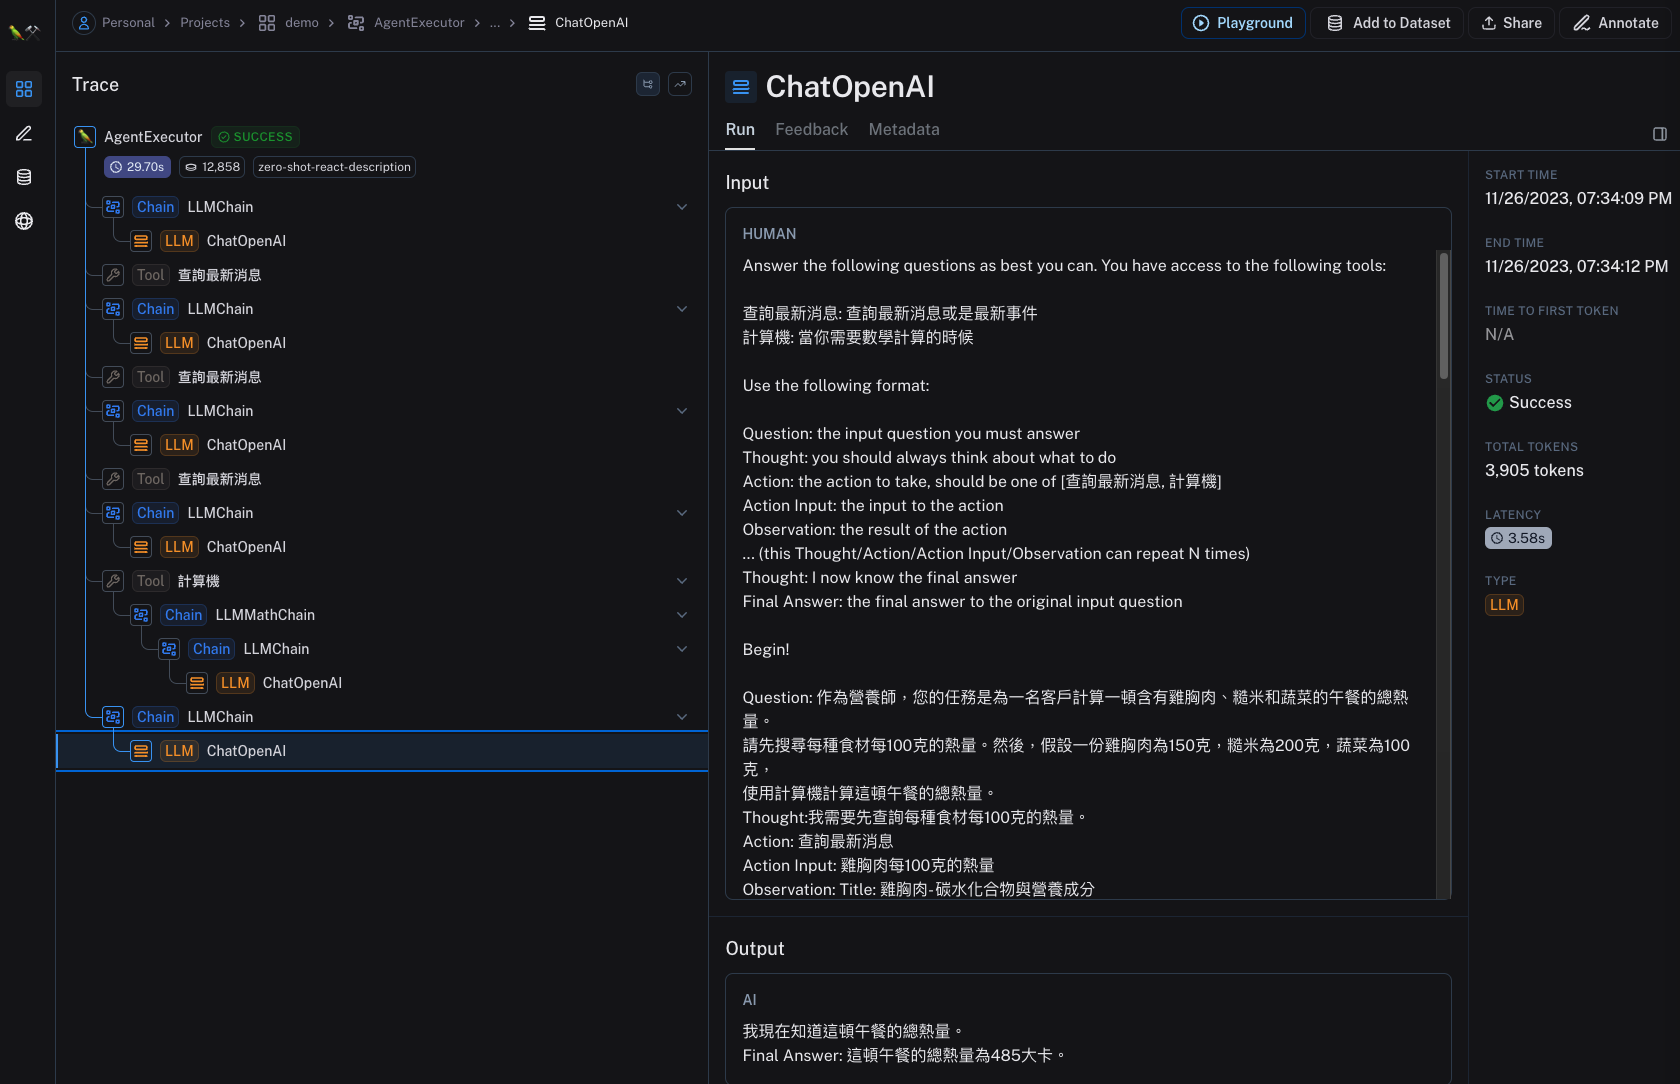